## Imports and Cleaning

In [21]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
!cd ~/Documents/Data_Projects/COVID/COVID-19

In [22]:
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', 150)
pd.set_option('display.max_rows', 150)

from datetime import timedelta
import math

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
mpl.rcParams['figure.dpi']= 600
sns.set()

import scipy.stats as stats
from scipy.optimize import curve_fit

import statsmodels.api as sm
from sklearn.metrics import r2_score

from data_clean import *
from model_helper import *
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [23]:
# Read in live data (countries from Johns Hopkins, states + count)
countries = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv')
states = pd.read_csv('https://raw.githubusercontent.com/nytimes/covid-19-data/master/us-states.csv')
local = pd.read_csv('https://raw.githubusercontent.com/nytimes/covid-19-data/master/us-counties.csv')

testing = pd.read_json('https://covidtracking.com/api/v1/states/daily.json')

In [24]:
df_country = clean_data_hopkins(countries, country='all')
df_state = clean_data_nyt(states, level='state')
df_local = clean_data_nyt(local, level='local')

df_testing = clean_data_trackingproject(testing)

/anaconda3/envs/covid/lib/python3.7/site-packages/pandas/core/series.py:679: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/anaconda3/envs/covid/lib/python3.7/site-packages/pandas/core/series.py:679: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [25]:
df_testing.loc[df_testing.State.isin(['NY'])].tail()

State        Date  Positive  Negative  Pending  HospitalizedCurrently  \
1272    NY  2020-04-04  113704.0  169917.0      NaN                15905.0   
1273    NY  2020-04-05  122031.0  180249.0      NaN                16479.0   
1274    NY  2020-04-06  130689.0  190122.0      NaN                16837.0   
1275    NY  2020-04-07  138863.0  201195.0      NaN                17493.0   
1276    NY  2020-04-08  149316.0  215837.0      NaN                18079.0   

      HospitalizedCumulative  InIcuCurrently  InIcuCumulative  \
1272                 26383.0          4126.0              NaN   
1273                 28092.0          4376.0              NaN   
1274                 30203.0          4504.0              NaN   
1275                 32083.0          4593.0              NaN   
1276                 32669.0          4593.0              NaN   

      OnVentilatorCurrently  OnVentilatorCumulative  Recovered   Death  \
1272                    NaN                     NaN    10478.0  3565.0   
1273                    NaN                     NaN    12187.0  4159.0   
1274                    NaN                     NaN    13366.0  4758.0   
1275                    NaN                     NaN    14590.0  5489.0   
1276                    NaN                     NaN    14590.0  6268.0   

      Hospitalized   Total  TotalTestResults  PosNeg  DeathIncrease  \
1272       26383.0  283621            283621  283621          630.0   
1273       28092.0  302280            302280  302280          594.0   
1274       30203.0  320811            320811  320811          599.0   
1275       32083.0  340058            340058  340058          731.0   
1276       32669.0  365153            365153  365153          779.0   

      HospitalizedIncrease  NegativeIncrease  PositiveIncrease  \
1272                2687.0           12260.0           10841.0   
1273                1709.0           10332.0            8327.0   
1274                2111.0            9873.0            8658.0   
1275                1880.0           11073.0            8174.0   
1276                 586.0           14642.0           10453.0   

      TotalTestResultsIncrease  
1272                   23101.0  
1273                   18659.0  
1274                   18531.0  
1275                   19247.0  
1276                   25095.0

In [26]:
df_state.loc[df_state.State == 'New York']

State        Date  Confirmed EpidemicStartDate  DaysElapsed  \
1239  New York  2020-03-01          1        2020-03-01            1   
1240  New York  2020-03-02          1        2020-03-01            2   
1241  New York  2020-03-03          2        2020-03-01            3   
1242  New York  2020-03-04         11        2020-03-01            4   
1243  New York  2020-03-05         22        2020-03-01            5   
1244  New York  2020-03-06         44        2020-03-01            6   
1245  New York  2020-03-07         89        2020-03-01            7   
1246  New York  2020-03-08        106        2020-03-01            8   
1247  New York  2020-03-09        142        2020-03-01            9   
1248  New York  2020-03-10        173        2020-03-01           10   
1249  New York  2020-03-11        217        2020-03-01           11   
1250  New York  2020-03-12        326        2020-03-01           12   
1251  New York  2020-03-13        421        2020-03-01           13   
1252  New York  2020-03-14        610        2020-03-01           14   
1253  New York  2020-03-15        732        2020-03-01           15   
1254  New York  2020-03-16        950        2020-03-01           16   
1255  New York  2020-03-17       1374        2020-03-01           17   
1256  New York  2020-03-18       2382        2020-03-01           18   
1257  New York  2020-03-19       4152        2020-03-01           19   
1258  New York  2020-03-20       7102        2020-03-01           20   
1259  New York  2020-03-21      10356        2020-03-01           21   
1260  New York  2020-03-22      15168        2020-03-01           22   
1261  New York  2020-03-23      20875        2020-03-01           23   
1262  New York  2020-03-24      25665        2020-03-01           24   
1263  New York  2020-03-25      33066        2020-03-01           25   
1264  New York  2020-03-26      38987        2020-03-01           26   
1265  New York  2020-03-27      44635        2020-03-01           27   
1266  New York  2020-03-28      53363        2020-03-01           28   
1267  New York  2020-03-29      59568        2020-03-01           29   
1268  New York  2020-03-30      67174        2020-03-01           30   
1269  New York  2020-03-31      75832        2020-03-01           31   
1270  New York  2020-04-01      83889        2020-03-01           32   
1271  New York  2020-04-02      92770        2020-03-01           33   
1272  New York  2020-04-03     102870        2020-03-01           34   
1273  New York  2020-04-04     114996        2020-03-01           35   
1274  New York  2020-04-05     122911        2020-03-01           36   
1275  New York  2020-04-06     130703        2020-03-01           37   
1276  New York  2020-04-07     140081        2020-03-01           38   
1277  New York  2020-04-08     149401        2020-03-01           39   

      NewConfirmed  DaysElapsed_Log  Confirmed_Log  NewConfirmed_Log  
1239           NaN         0.000000       0.000000               NaN  
1240           0.0         0.693147       0.000000              -inf  
1241           1.0         1.098612       0.693147          0.000000  
1242           9.0         1.386294       2.397895          2.197225  
1243          11.0         1.609438       3.091042          2.397895  
1244          22.0         1.791759       3.784190          3.091042  
1245          45.0         1.945910       4.488636          3.806662  
1246          17.0         2.079442       4.663439          2.833213  
1247          36.0         2.197225       4.955827          3.583519  
1248          31.0         2.302585       5.153292          3.433987  
1249          44.0         2.397895       5.379897          3.784190  
1250         109.0         2.484907       5.786897          4.691348  
1251          95.0         2.564949       6.042633          4.553877  
1252         189.0         2.639057       6.413459          5.241747  
1253         122.0         2.708050       6.595781          4.8

In [27]:
df_country.loc[df_country.Country=='US'].tail(3)

Country        Date  Confirmed EpidemicStartDate  DaysElapsed  \
13971      US  2020-04-06     366667        2020-01-22           76   
14155      US  2020-04-07     396223        2020-01-22           77   
14339      US  2020-04-08     429052        2020-01-22           78   

       NewConfirmed  DaysElapsed_Log  Confirmed_Log  NewConfirmed_Log  
13971       29595.0         4.330733      12.812209         10.295361  
14155       29556.0         4.343805      12.889732         10.294042  
14339       32829.0         4.356709      12.969333         10.399068

In [28]:
US = df_country.loc[df_country.Country=='US']
US.tail(3)

Country        Date  Confirmed EpidemicStartDate  DaysElapsed  \
13971      US  2020-04-06     366667        2020-01-22           76   
14155      US  2020-04-07     396223        2020-01-22           77   
14339      US  2020-04-08     429052        2020-01-22           78   

       NewConfirmed  DaysElapsed_Log  Confirmed_Log  NewConfirmed_Log  
13971       29595.0         4.330733      12.812209         10.295361  
14155       29556.0         4.343805      12.889732         10.294042  
14339       32829.0         4.356709      12.969333         10.399068

## Regression of Actual Cases

In [29]:
US_trimmed = US[US.Date > pd.to_datetime('2020-03-01').date()]
US_trimmed.head(3)

Country        Date  Confirmed EpidemicStartDate  DaysElapsed  \
7531      US  2020-03-02         98        2020-01-22           41   
7715      US  2020-03-03        118        2020-01-22           42   
7899      US  2020-03-04        149        2020-01-22           43   

      NewConfirmed  DaysElapsed_Log  Confirmed_Log  NewConfirmed_Log  
7531          24.0         3.713572       4.584967          3.178054  
7715          20.0         3.737670       4.770685          2.995732  
7899          31.0         3.761200       5.003946          3.433987

### Fitting Exponential

In [41]:
x = US_trimmed.DaysElapsed.values
y = US_trimmed.Confirmed.values

In [42]:
# Regressing on last 14 days
params, covar = curve_fit(lambda t,a,b: a*np.exp(b*t),  x[-14:],  y[-14:], p0=(2,.1))
y_hat_scipy = params[0]*np.exp(params[1]*x)
r2_scipy = r2_score(y, y_hat_scipy)

In [43]:
# Unweighted Regression (Higher magnitudes of Y implicitly weighted higher)
params = np.polyfit(x, np.log(y), 1, w=np.sqrt(y))
y_hat_numpy = np.exp(params[1]) * np.exp(params[0] * x)
r2_numpy = r2_score(y, y_hat_numpy)

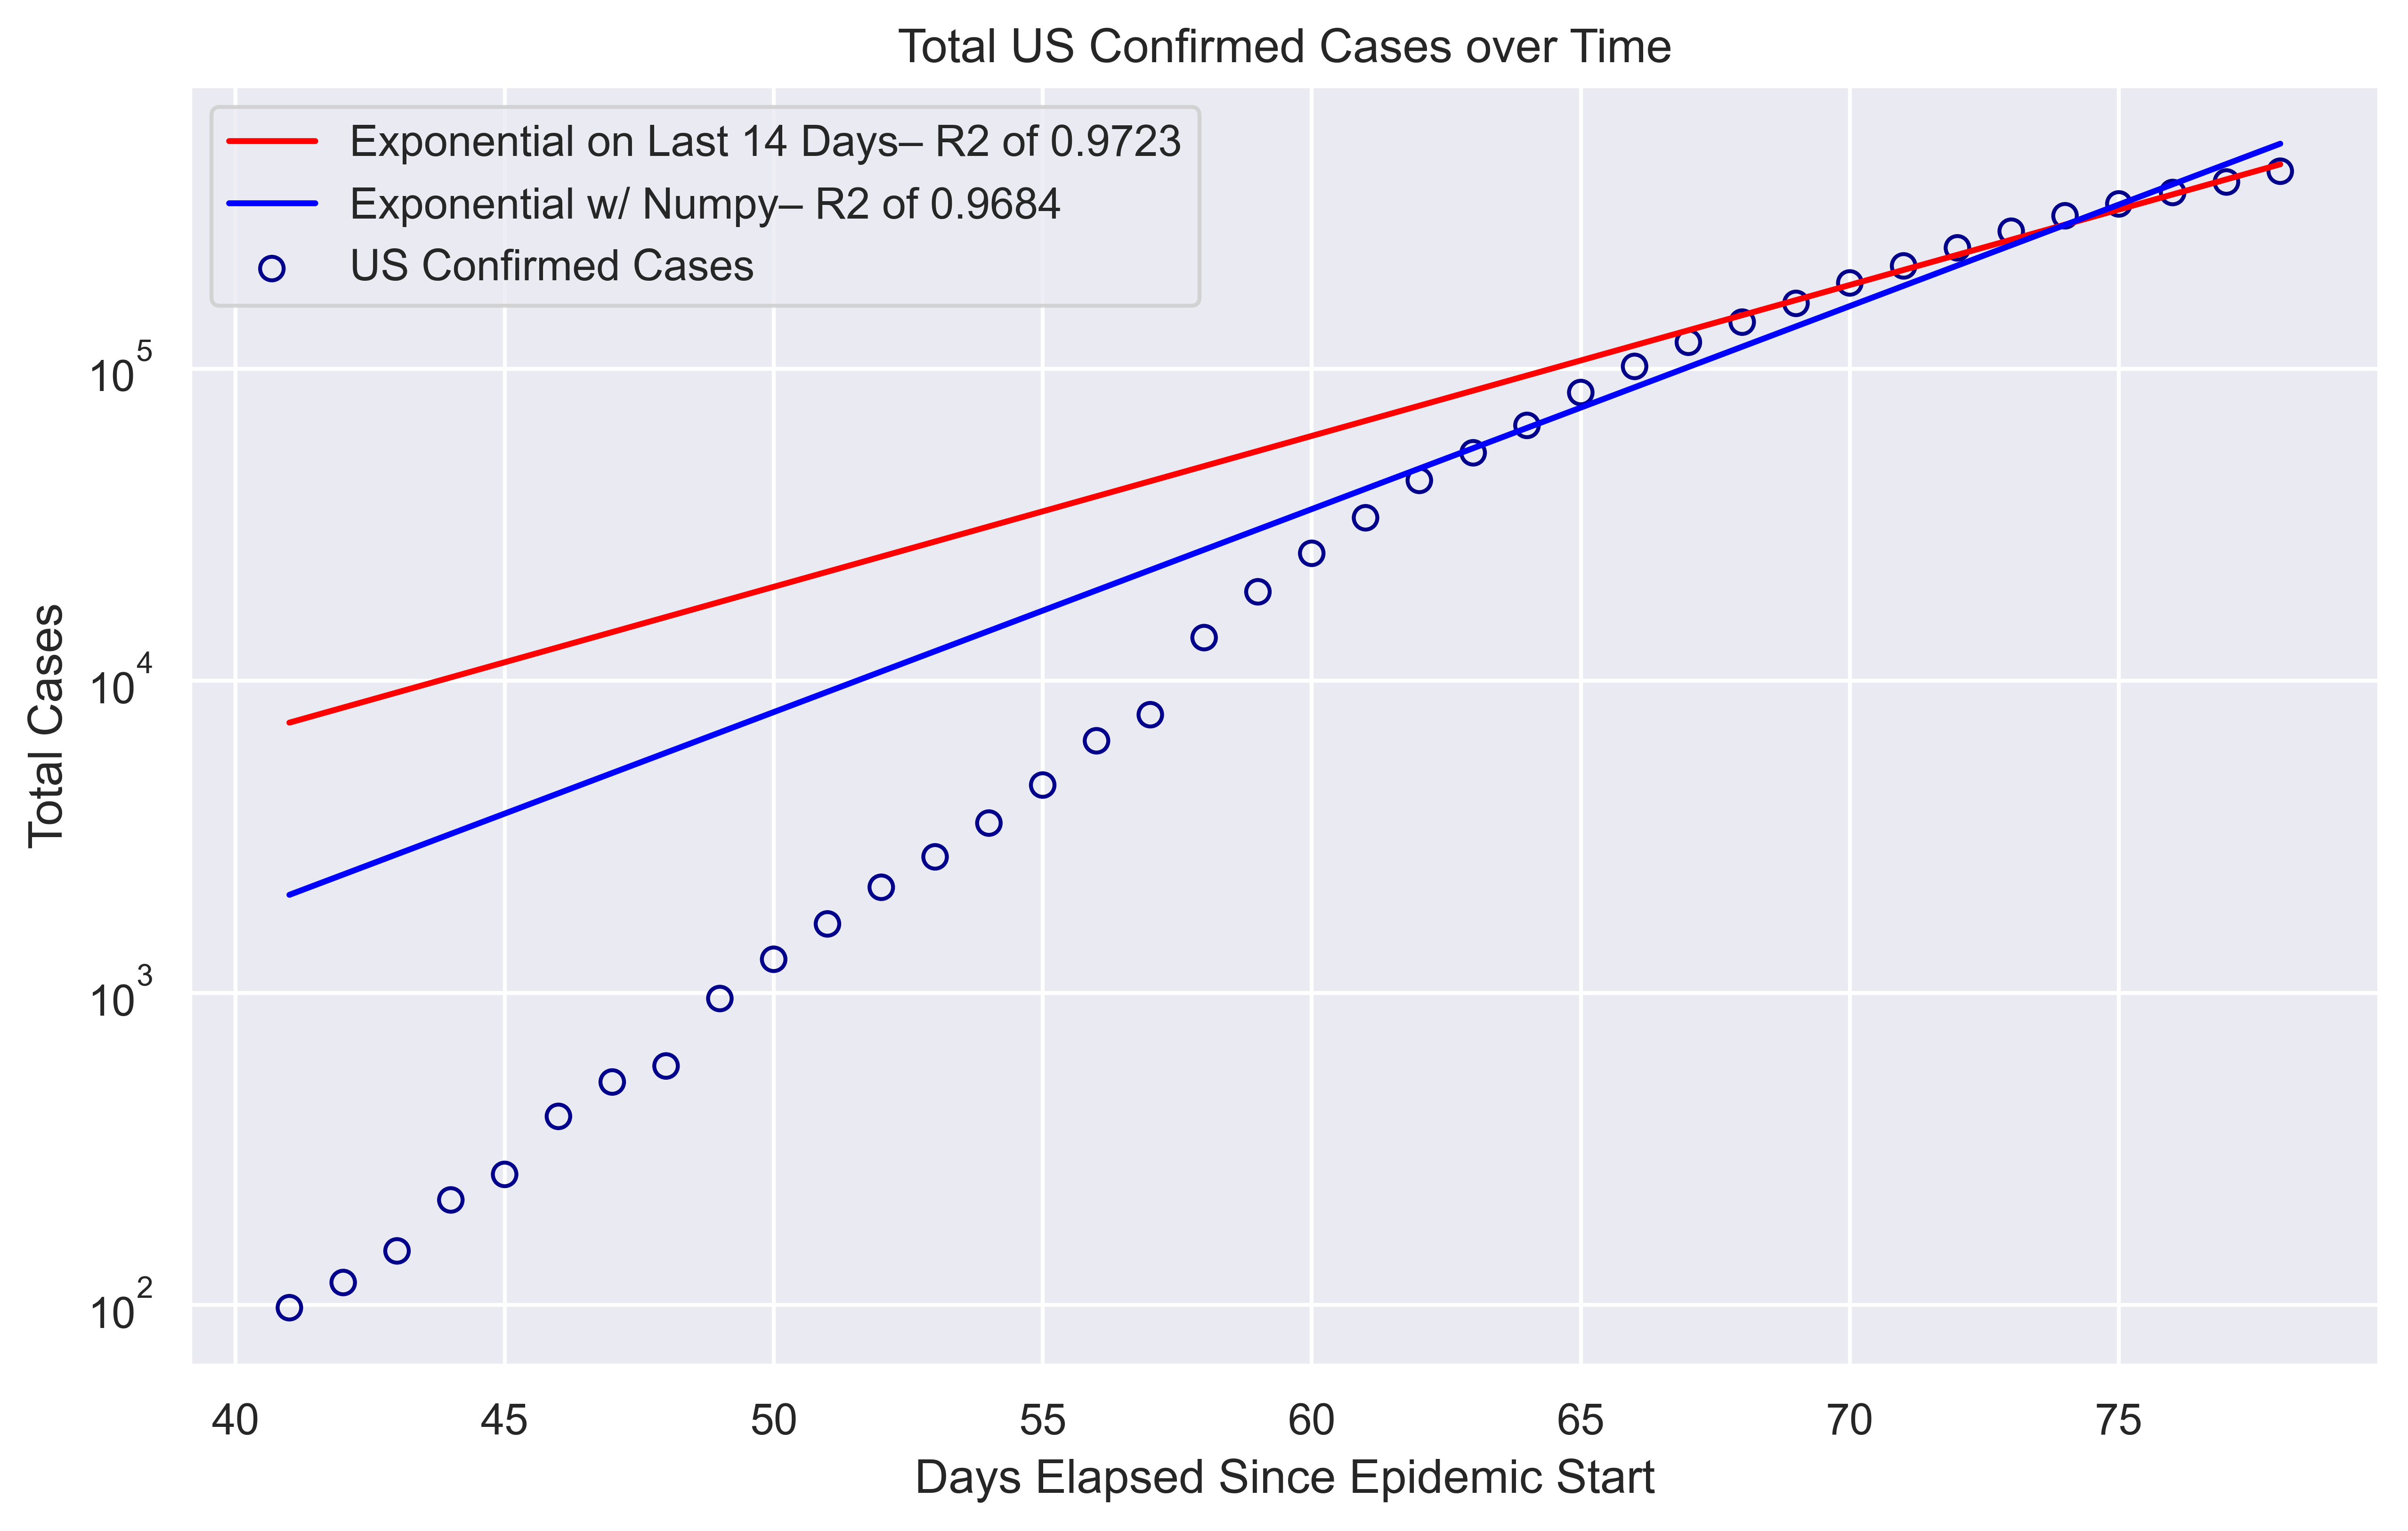

In [44]:
## Make this into log v unlogged side by side comparison

plt.figure(figsize=(10,6))
plt.scatter(x, y, facecolors = 'none', edgecolor = 'darkblue', label = 'US Confirmed Cases')
plt.plot(x, y_hat_scipy, color = 'red', label = 'Exponential on Last 14 Days– R2 of %2.4f'%r2_scipy)
plt.plot(x, y_hat_numpy, color = 'blue', label = 'Exponential w/ Numpy– R2 of %2.4f'%r2_numpy)

plt.yscale('log') 

plt.legend()
plt.ylabel('Total Cases')
plt.xlabel('Days Elapsed Since Epidemic Start')
plt.title('Total US Confirmed Cases over Time')
plt.show()

### Using weighted local regression (LOWESS)

In [45]:
x = US_trimmed.DaysElapsed.values
y = US_trimmed.Confirmed.values

In [46]:
lowess = regress(x, y, how='lowess')

d = 3
x_range, y_hat = predict(x, lowess[1], days=d, extend=False)

preds = pd.DataFrame(list(zip(x_range, np.around(y_hat,2))), columns =['DaysElapsed', 'ConfirmedPred']) 
preds

R2 for lowess: 0.99993


DaysElapsed  ConfirmedPred
0           79      458062.17
1           80      488325.87
2           81      518589.57

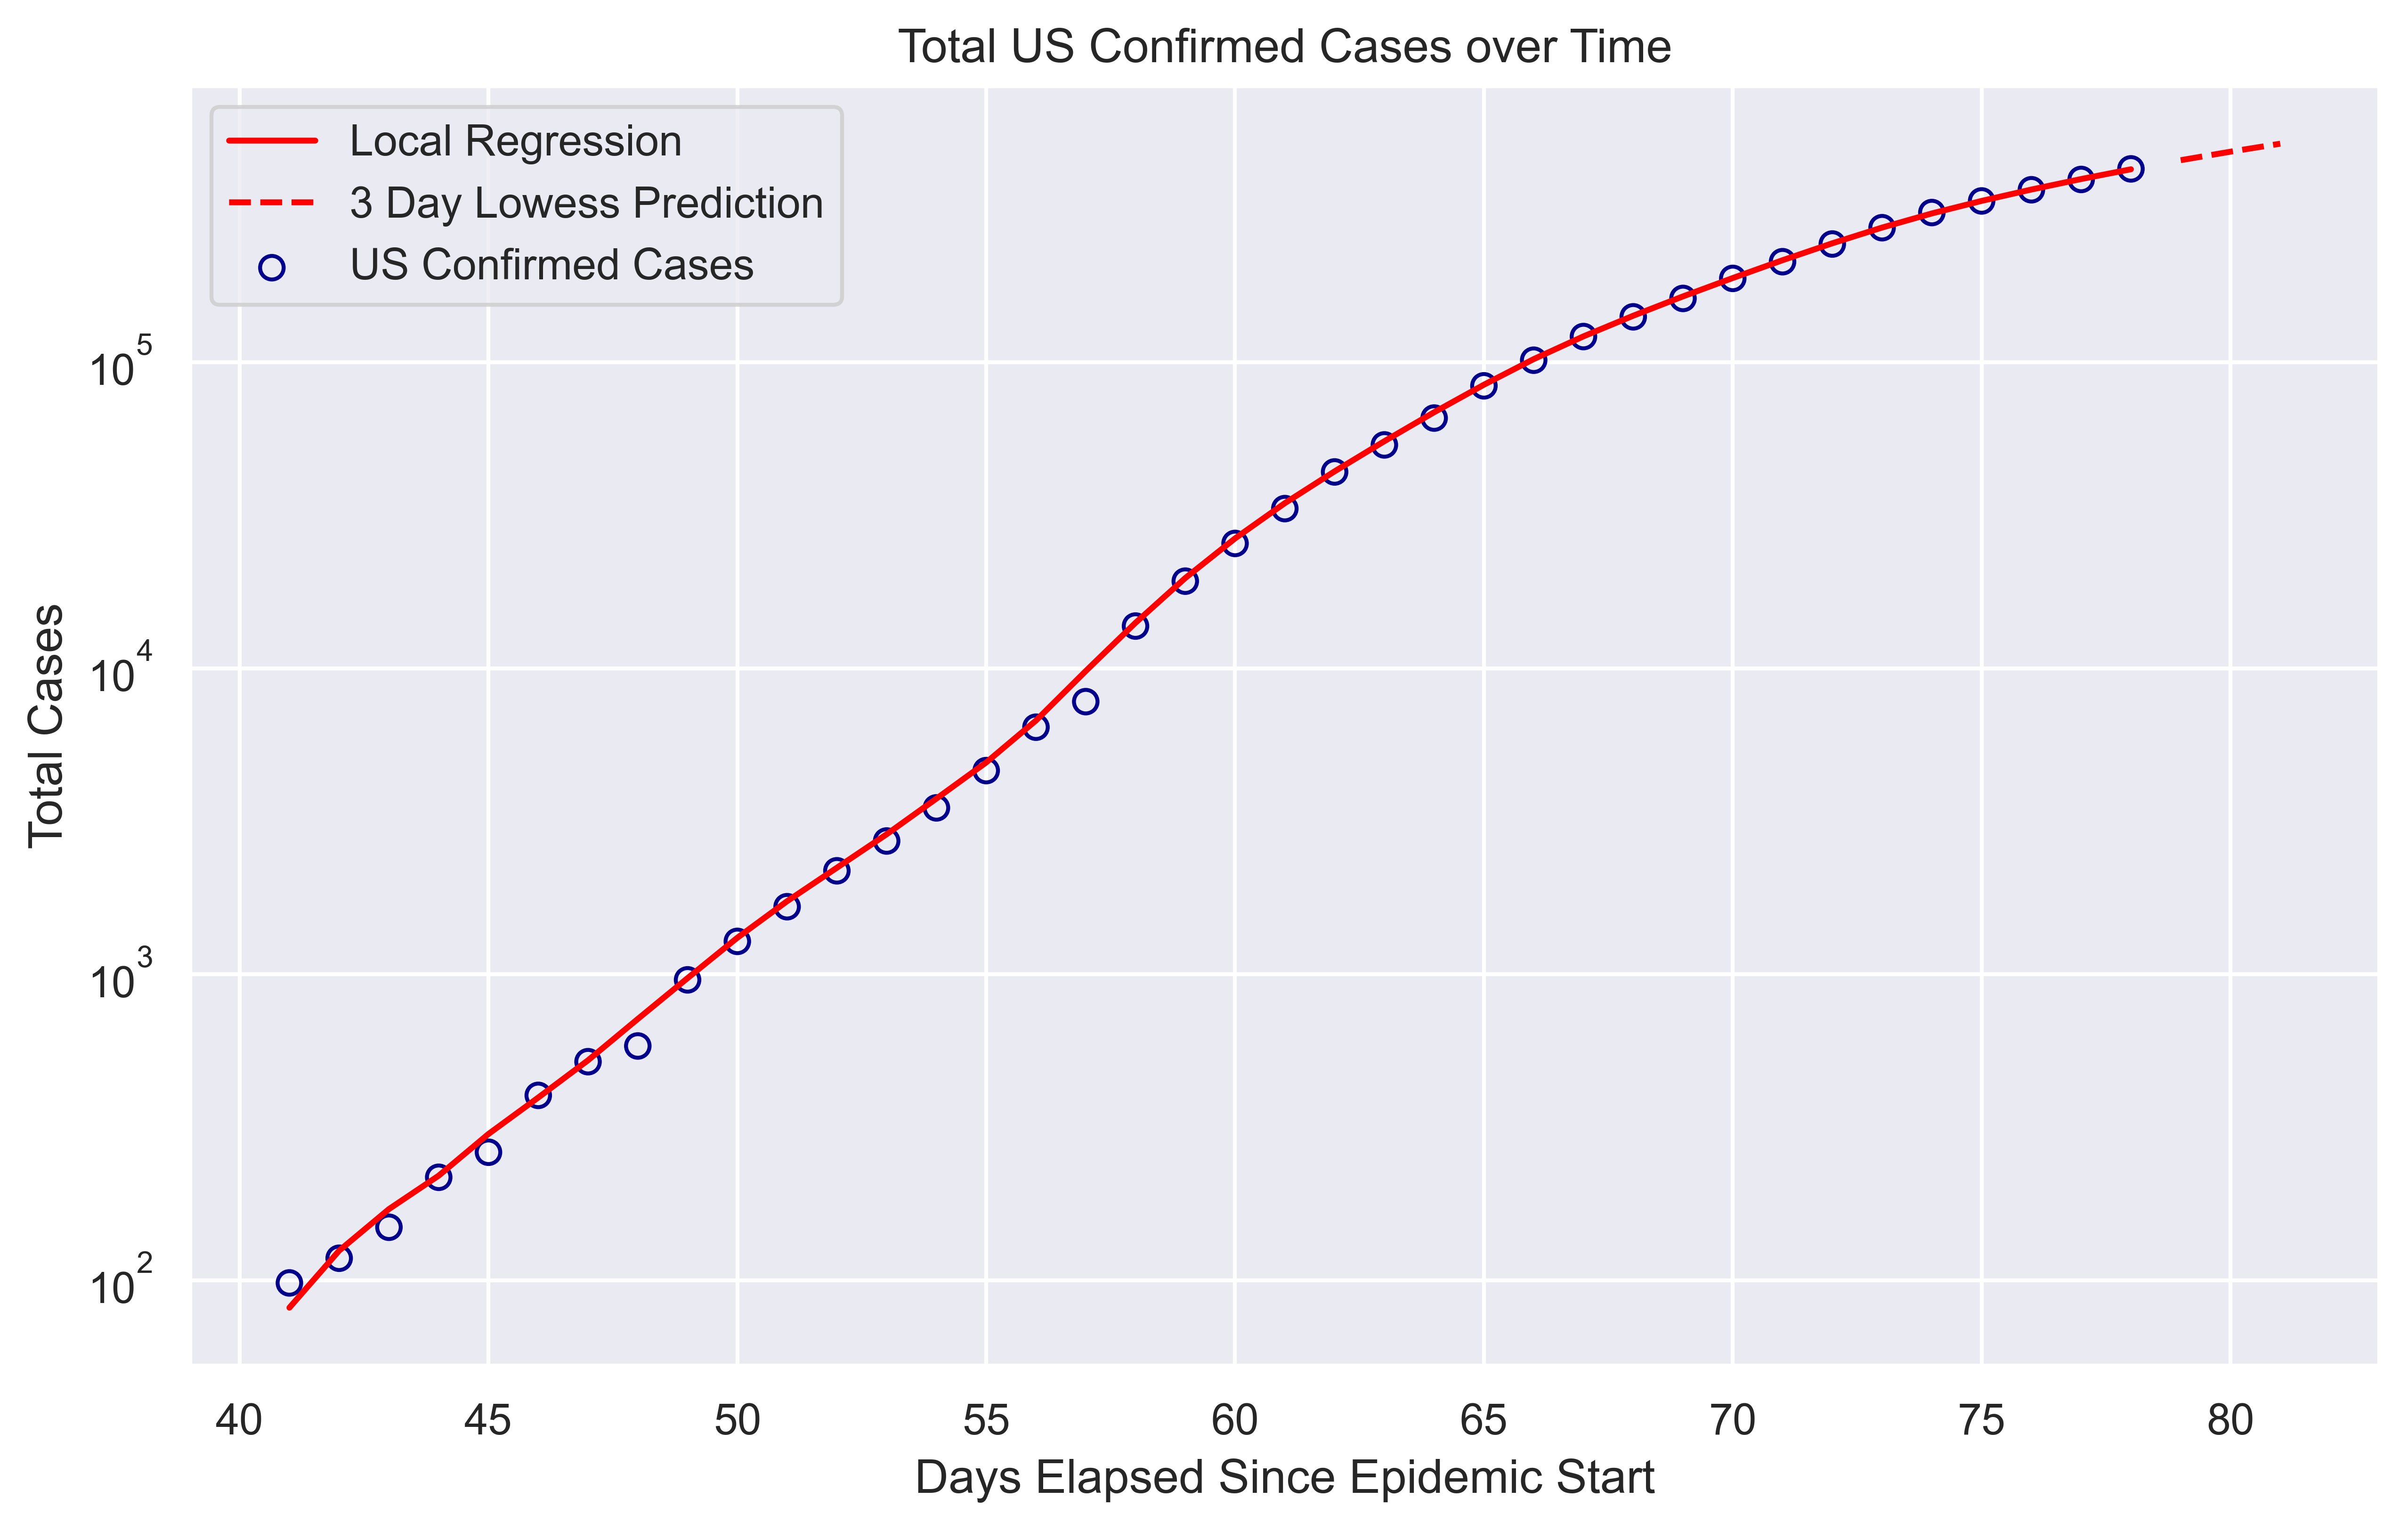

In [47]:
plt.figure(figsize=(10,6))
plt.scatter(x, y, facecolors = 'none', edgecolor = 'darkblue', label = 'US Confirmed Cases')
plt.plot(x, lowess[1], color = 'red', label = 'Local Regression')
# plt.plot(x, exp[1], color = 'orange', label = 'exp')

plt.plot(x_range, y_hat, '--', color = 'red', label = '{} Day Lowess Prediction'.format(d))
# plt.plot(x_extended, y_hat_exp, color = 'orange', label = 'exp')

plt.yscale('log')

plt.legend()
plt.ylabel('Total Cases')
plt.xlabel('Days Elapsed Since Epidemic Start')
plt.title('Total US Confirmed Cases over Time')
plt.show()

### Using compounded growth

Using the logarithmic approximation

In [48]:
x = US_trimmed.DaysElapsed.values[1:]
y = US_trimmed.Confirmed_Log.diff(periods=1).values[1:] 

In [49]:
# Only consider the last 2 weeks to regress on
params = np.polyfit(x[-14:],y[-14:],deg=1)
# params = np.polyfit(x,y,deg=1,w=x**2)
y_hat = x*params[0]+params[1]

y_t_1 = 366667
x_t = 76
y_t = y_t_1*np.exp(params[0]*x_t+params[1])
r2_score(y, y_hat)
# Create recursive prediction method

0.0977896881407857

In [50]:
params

array([-0.01067572,  0.89726327])

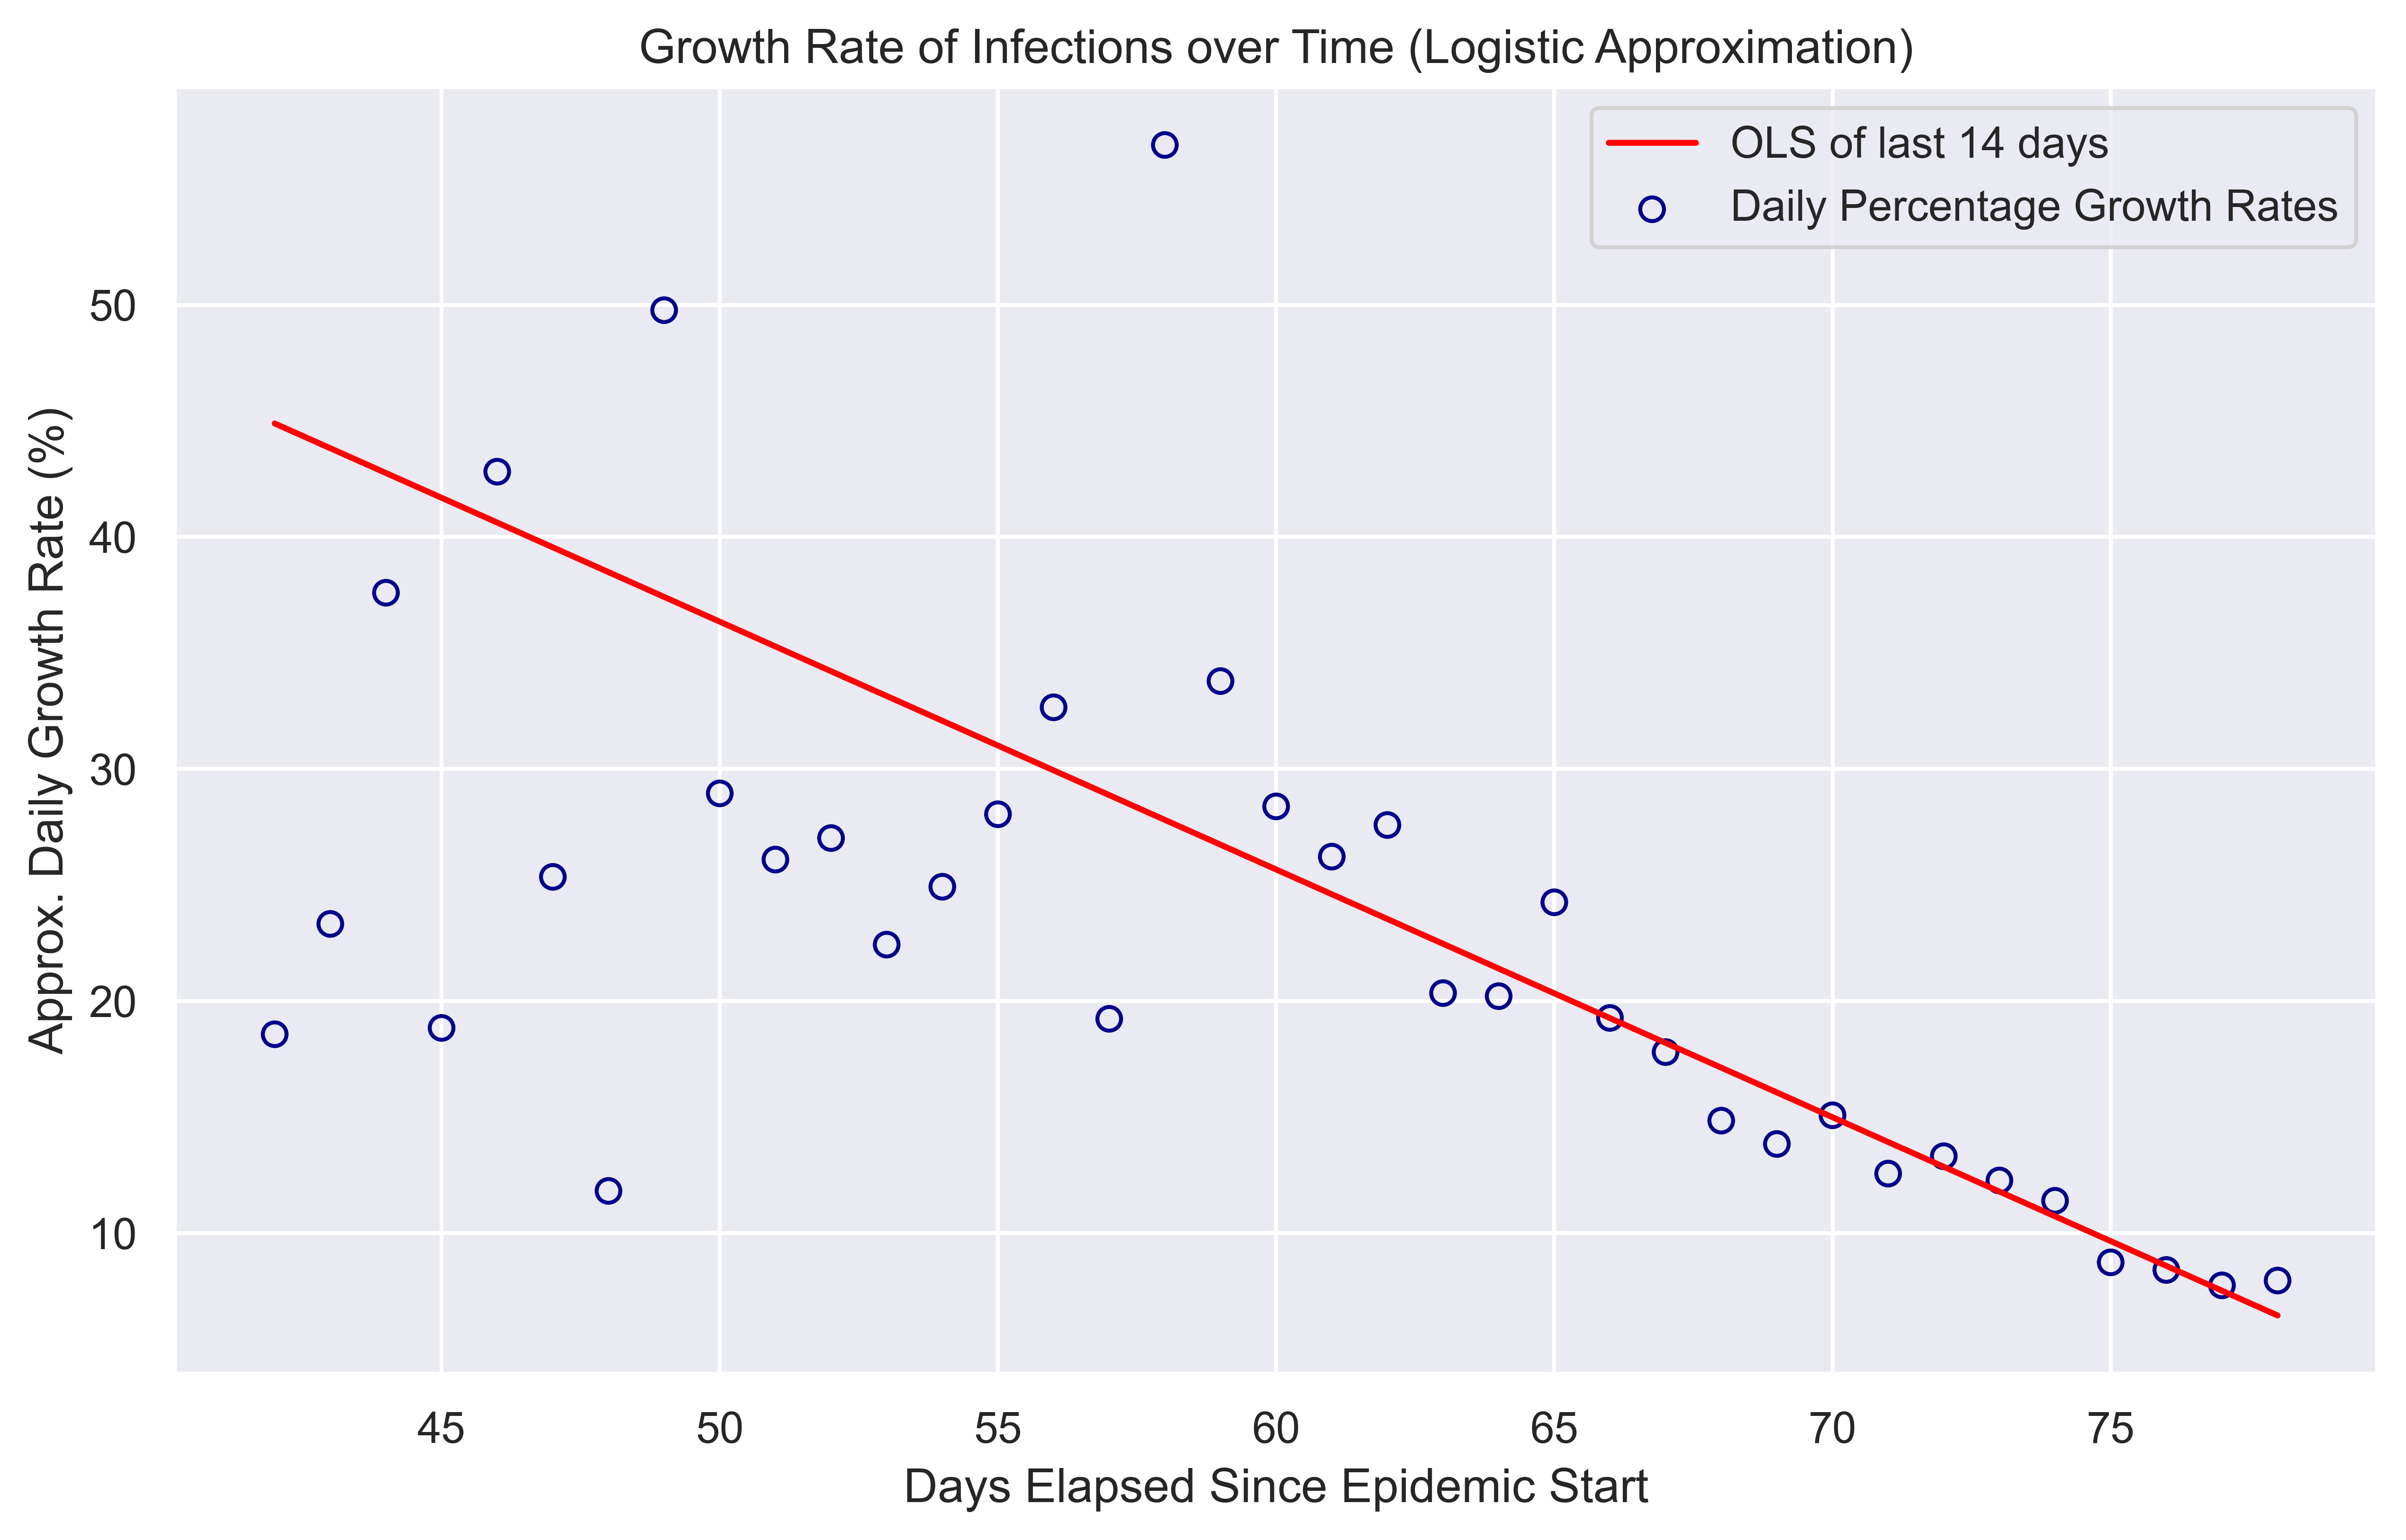

In [51]:
plt.figure(figsize=(10,6))
plt.scatter(x, y*100, facecolors = 'none', edgecolor = 'darkblue', label = 'Daily Percentage Growth Rates')
plt.plot(x, y_hat*100, color = 'red', label = 'OLS of last 14 days')
# plt.plot(x, exp[1], color = 'orange', label = 'exp')a


# ax.set_yticklabels(['{:,.2%}'.format(y) for y in ax.get_yticks()])

plt.legend()
plt.ylabel('Approx. Daily Growth Rate (%)')
plt.xlabel('Days Elapsed Since Epidemic Start')
plt.title('Growth Rate of Infections over Time (Logistic Approximation)')
plt.show()

Using actual daily growth rate in confirmed cases

In [20]:
x = US_trimmed.DaysElapsed.values[1:]
y = (US_trimmed.Confirmed/US_trimmed.Confirmed.shift(1)).values[1:]

In [21]:
# Only consider the last 2 weeks to regress on
params = np.polyfit(x[-14:],y[-14:],deg=1)
# params = np.polyfit(x,y,deg=1,w=x**2)
y_hat = x*params[0]+params[1]

# y_t_1 = 366667
# x_t = 76
# y_t = y_t_1*np.exp(params[0]*x_t+params[1])
r2_score(y, y_hat)
# # Create recursive prediction method

0.18497268427712588

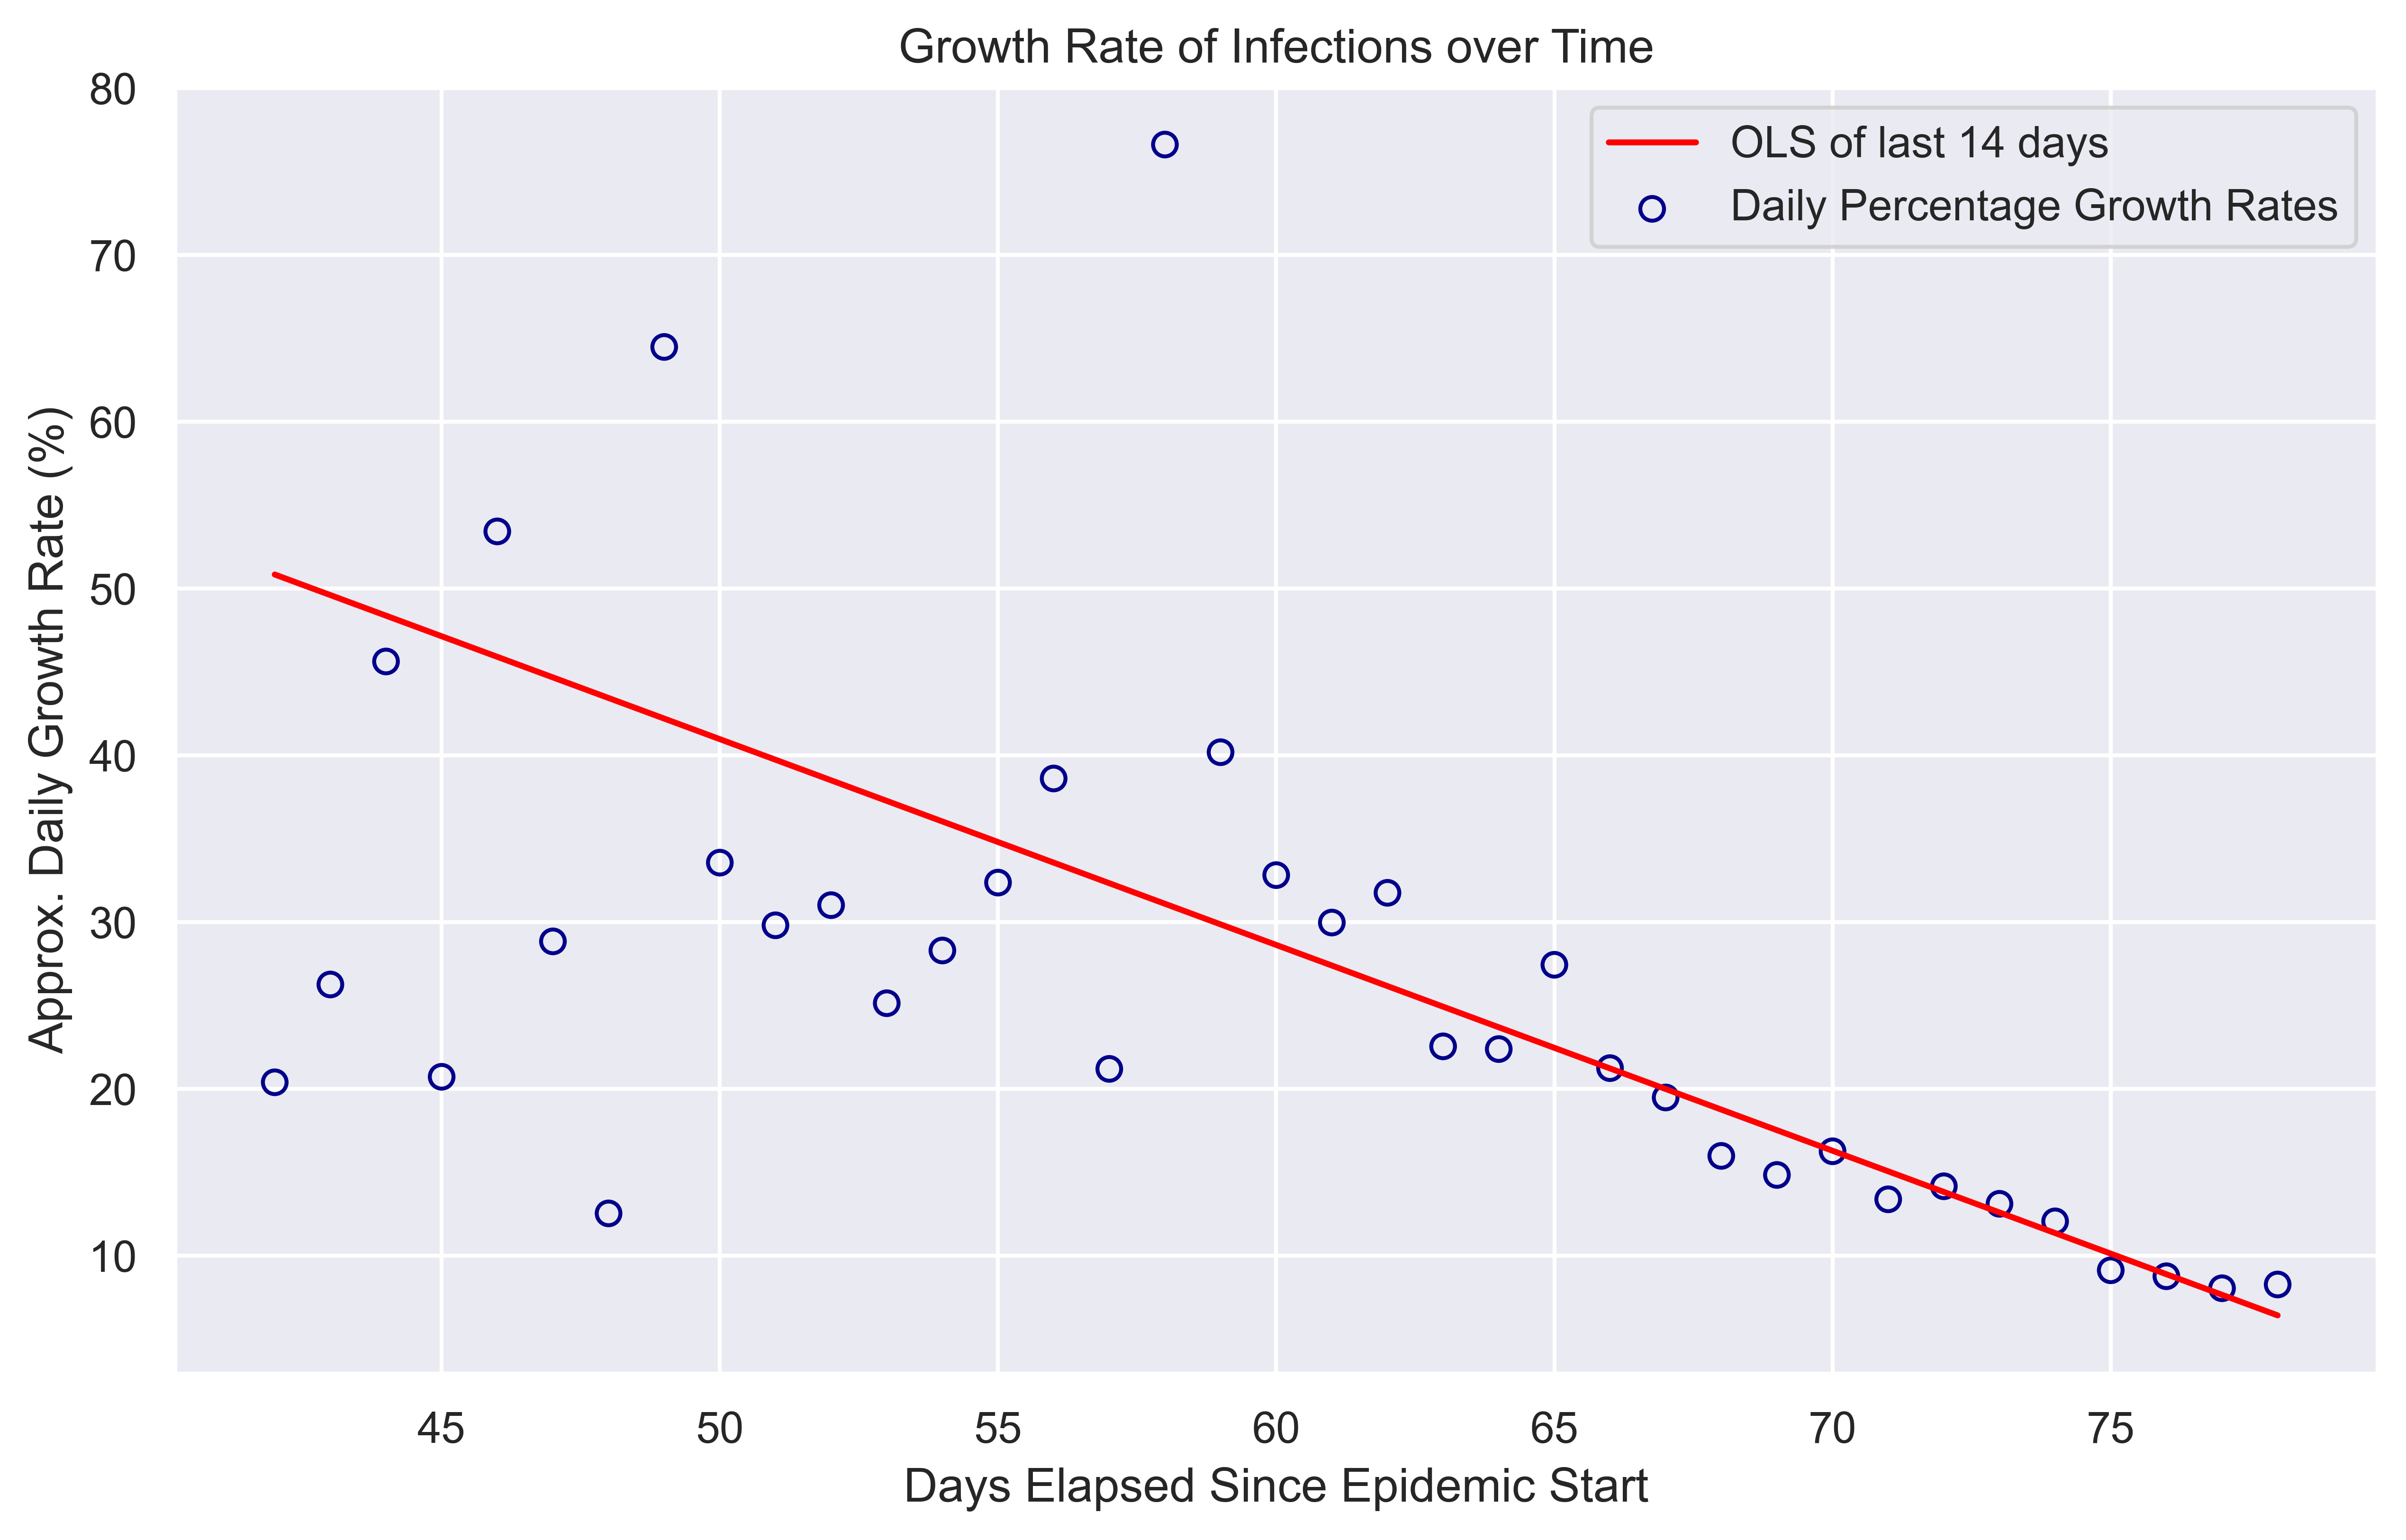

In [22]:
plt.figure(figsize=(10,6))
plt.scatter(x, y*100-100, facecolors = 'none', edgecolor = 'darkblue', label = 'Daily Percentage Growth Rates')
plt.plot(x, y_hat*100-100, color = 'red', label = 'OLS of last 14 days')
# plt.plot(x, exp[1], color = 'orange', label = 'exp')a


# ax.set_yticklabels(['{:,.2%}'.format(y) for y in ax.get_yticks()])

plt.legend()
plt.ylabel('Approx. Daily Growth Rate (%)')
plt.xlabel('Days Elapsed Since Epidemic Start')
plt.title('Growth Rate of Infections over Time')
plt.show()

### Regressing Logistic

Adapted from https://www.kaggle.com/lucaalbrizzo/robusteness-fits-and-mortality-rates-for-covid-19

In [23]:
from lmfit.models import StepModel
model_log = StepModel(form='logistic')
params_log = model_log.guess(US_trimmed.Confirmed, x=US_trimmed.DaysElapsed)
result_log = model_log.fit(US_trimmed.Confirmed, params_log, x=US_trimmed.DaysElapsed)

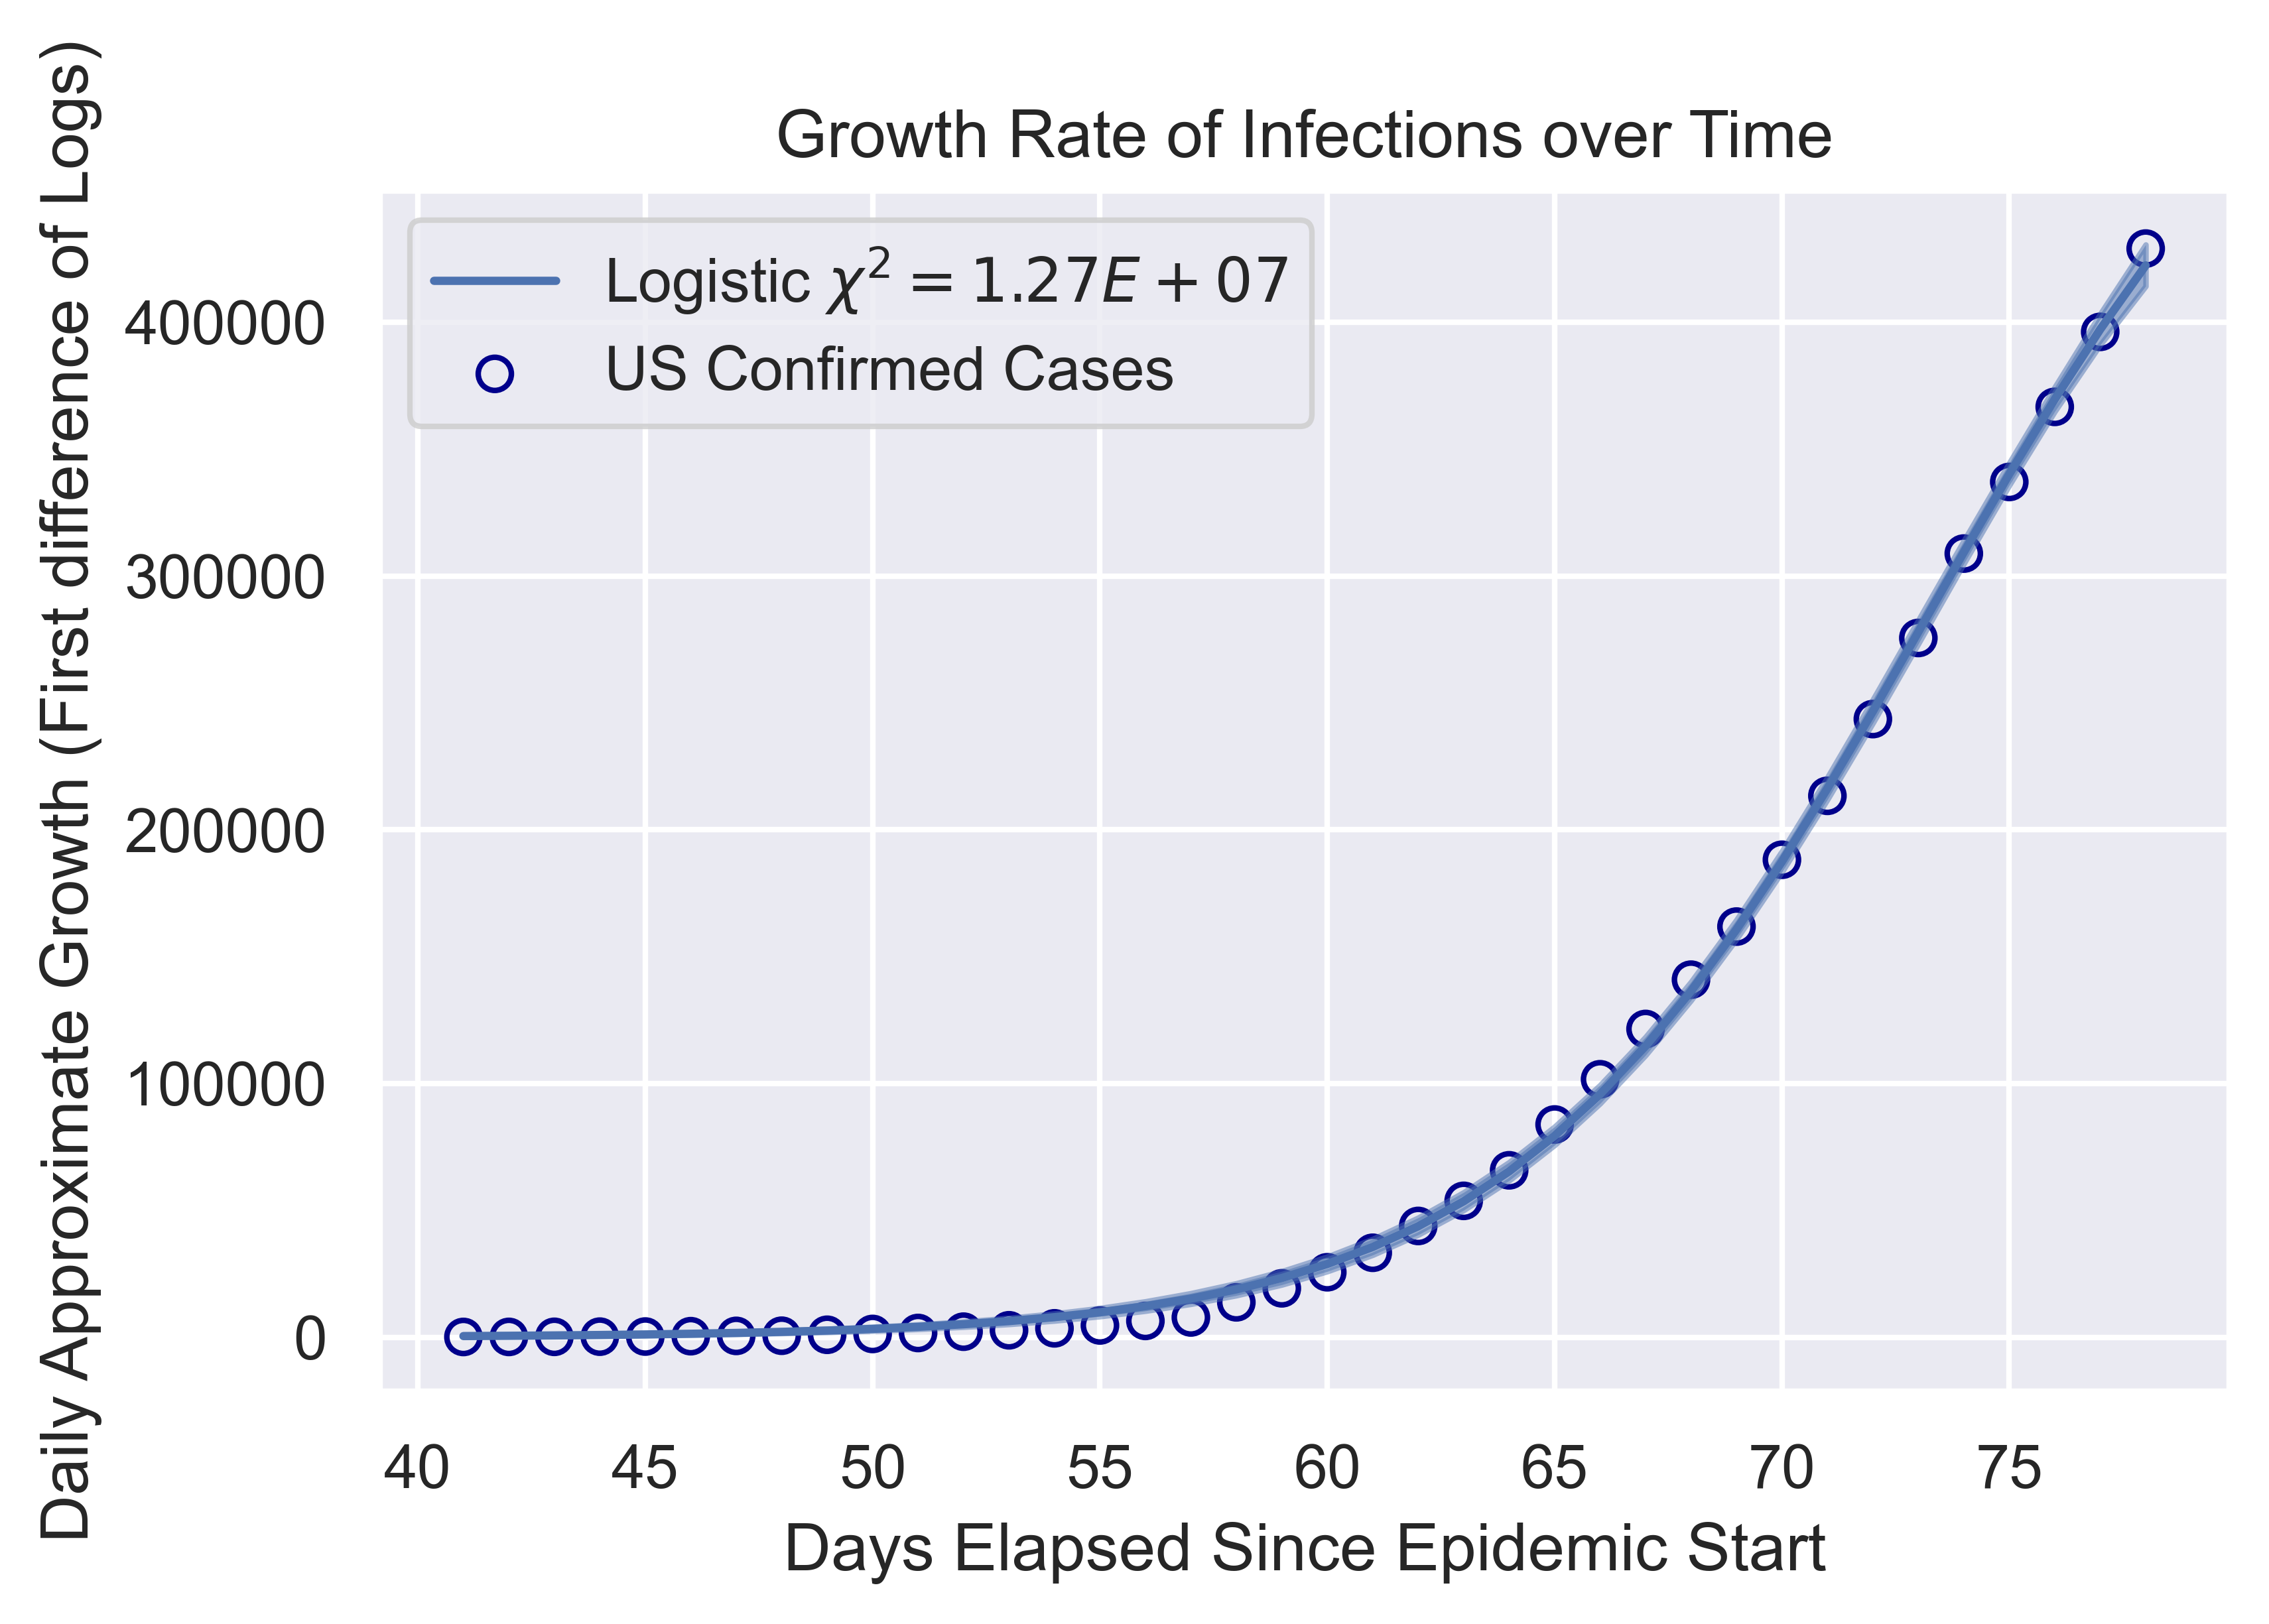

In [24]:
tf = np.array([i for i in range(min(US_trimmed.DaysElapsed),max(US_trimmed.DaysElapsed)+21)])

plt.plot(US_trimmed.DaysElapsed, result_log.best_fit, color='b',
         label="Logistic $\chi^2 = {:.2E}$".format(result_log.redchi))
plt.scatter(US_trimmed.DaysElapsed, US_trimmed.Confirmed, 
            facecolors = 'none', edgecolor = 'darkblue', label = 'US Confirmed Cases')

dely_log = result_log.eval_uncertainty(x=US_trimmed.DaysElapsed,sigma=3)
plt.fill_between(US_trimmed.DaysElapsed, 
                 result_log.best_fit-dely_log,
                 result_log.best_fit+dely_log, 
                 color='b',
                 alpha=0.5)



# plt.yscale('log')

plt.legend()
plt.ylabel('Daily Approximate Growth (First difference of Logs)')
plt.xlabel('Days Elapsed Since Epidemic Start')
plt.title('Growth Rate of Infections over Time')
plt.show()

## Modelling using SIR

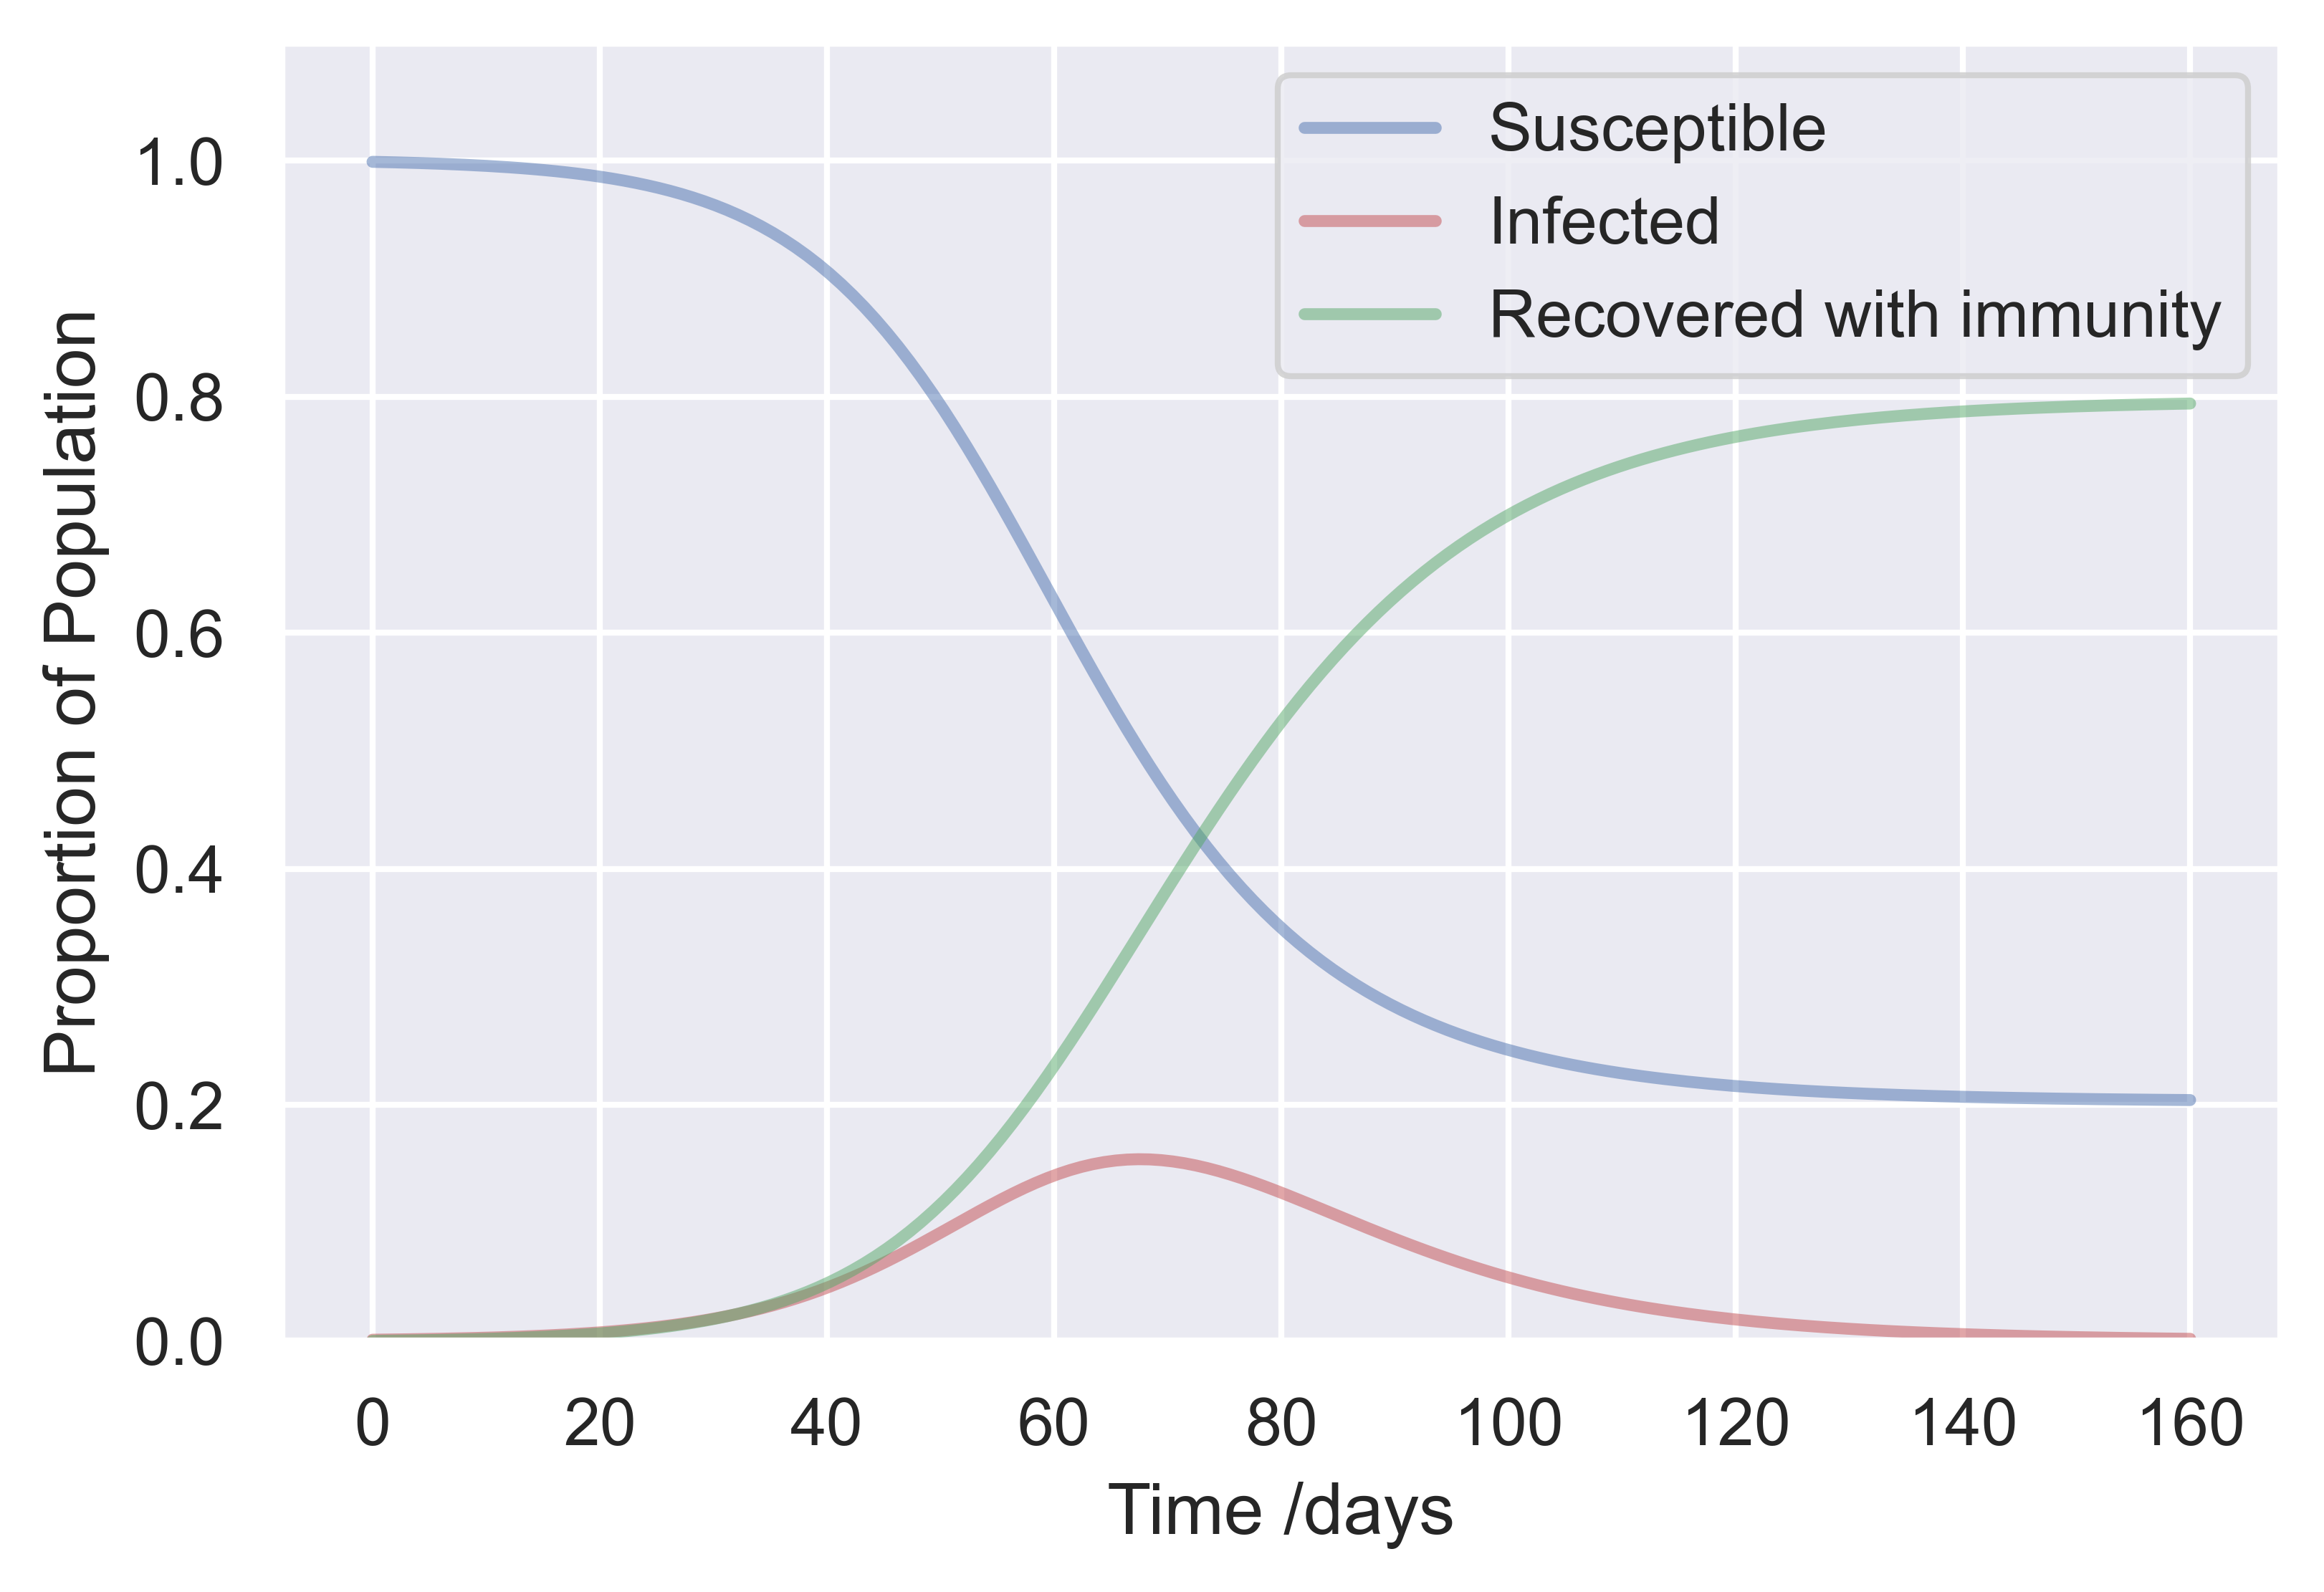

In [56]:
## From https://scipython.com/book/chapter-8-scipy/additional-examples/the-sir-epidemic-model/

import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

# Total population, N.
N = 1000
# Initial number of infected and recovered individuals, I0 and R0.
I0, R0 = 1, 0
# Everyone else, S0, is susceptible to infection initially.
S0 = N - I0 - R0
# Contact rate, beta, and mean recovery rate, gamma, (in 1/days).
beta, gamma = 0.2, 1./10 
# A grid of time points (in days)
t = np.linspace(0, 160, 160)

# The SIR model differential equations.
def deriv(y, t, N, beta, gamma):
    S, I, R = y
    dSdt = -beta * S * I / N
    dIdt = beta * S * I / N - gamma * I
    dRdt = gamma * I
    return dSdt, dIdt, dRdt

# Initial conditions vector
y0 = S0, I0, R0
# Integrate the SIR equations over the time grid, t.
ret = odeint(deriv, y0, t, args=(N, beta, gamma))
S, I, R = ret.T

# Plot the data on three separate curves for S(t), I(t) and R(t)
fig = plt.figure(facecolor='w')
ax = fig.add_subplot(111, axisbelow=True)
ax.plot(t, S/N, 'b', alpha=0.5, lw=2, label='Susceptible')
ax.plot(t, I/N, 'r', alpha=0.5, lw=2, label='Infected')
ax.plot(t, R/N, 'g', alpha=0.5, lw=2, label='Recovered with immunity')
ax.set_xlabel('Time /days')
ax.set_ylabel('Proportion of Population')
ax.set_ylim(0,1.1)
# ax.yaxis.set_tick_params(length=0)
# ax.xaxis.set_tick_params(length=0)
# ax.grid(b=True, which='major', c='w', lw=2, ls='-')
legend = ax.legend()
# legend.get_frame().set_alpha(0.5)
# for spine in ('top', 'right', 'bottom', 'left'):
#     ax.spines[spine].set_visible(False)
plt.show()

      fun: 7399.717344235348
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 3.02481733e+10, -5.85112008e+04])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 186
      nit: 4
   status: 0
  success: True
        x: array([1.6138210e-07, 5.7684019e-05])
country=US, beta=0.00000016, gamma=0.00005768, r_0:0.00279769


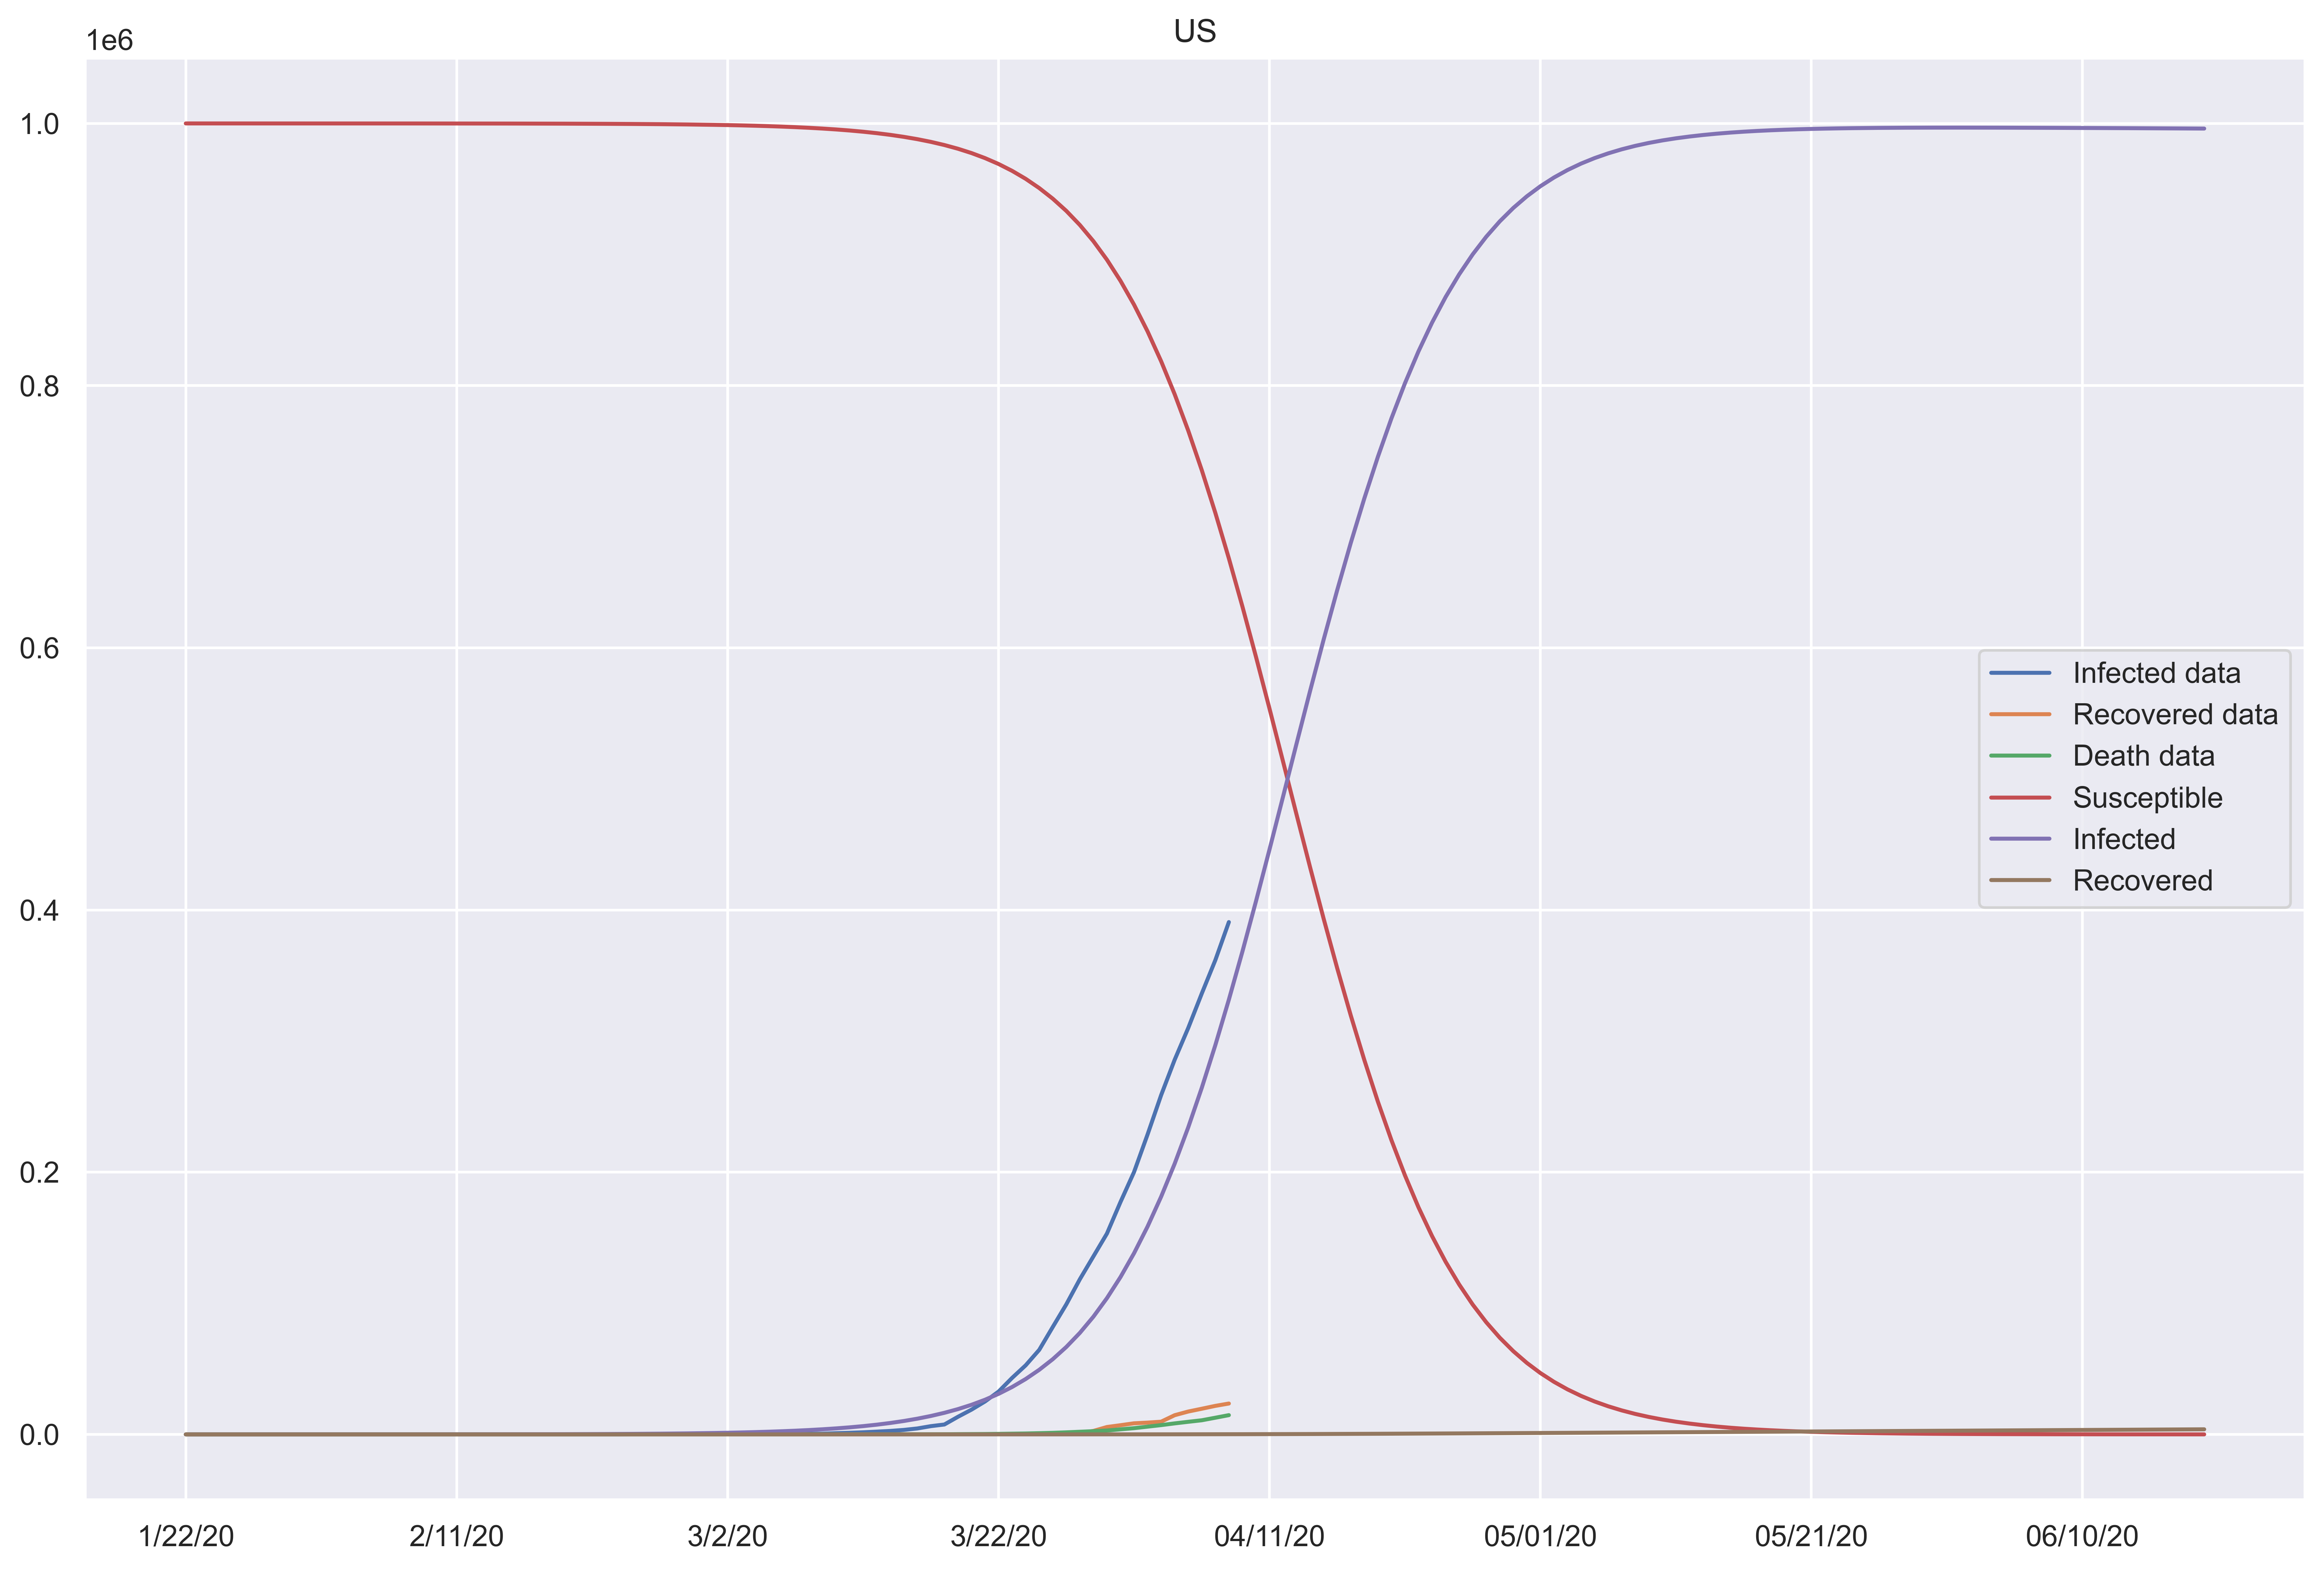

In [53]:
from lewuathe_SIR import * 

countries =  'US'
startdate = '1/22/20'
predict_range = 150
s_0, i_0, r_0 = 1000000, 2, 0


learner = Learner('US', loss, startdate, predict_range, s_0, i_0, r_0)
    #try:
learner.train()
        #except BaseException:
        #    print('WARNING: Problem processing ' + str(country) +
        #        '. Be sure it exists in the data exactly as you entry it.' +
        #        ' Also check date format if you passed it as parameter.')